In [71]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [72]:
scores_dir = Path("designed/scores")
combined_dir = Path("designed/combined")
max_round = 4
nanobodies = ["H11-D4", "Nb21", "Ty1", "VHH-72"]
score_types = ["log_likelihood_ratio", "Interface_pLDDT", "Interface_Residue_Count", "Interface_Atom_Count", "dG_separated", "weighted_score"]

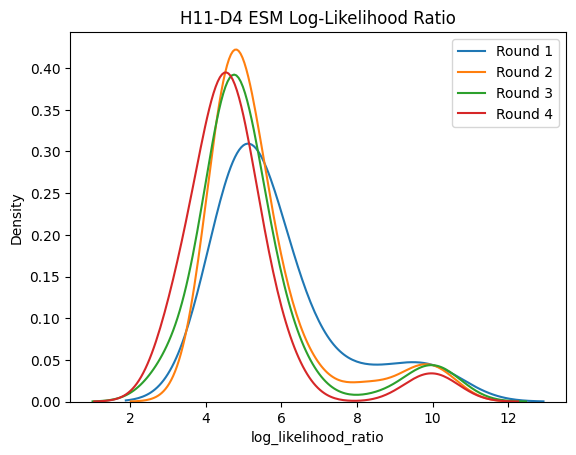

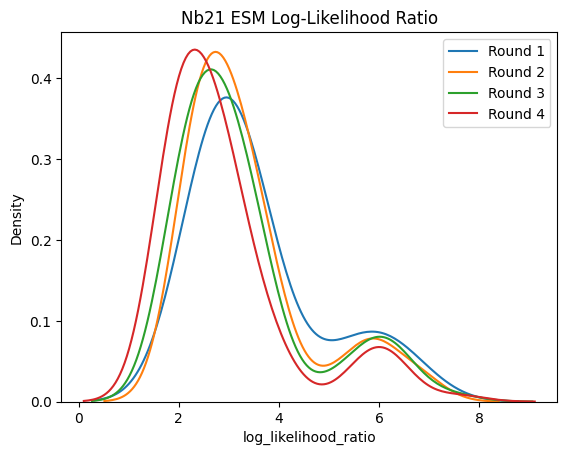

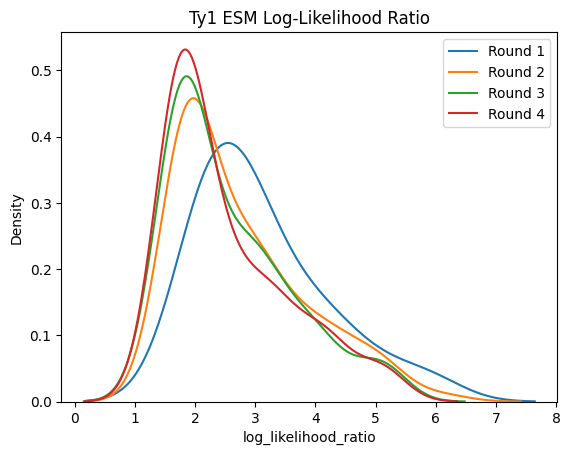

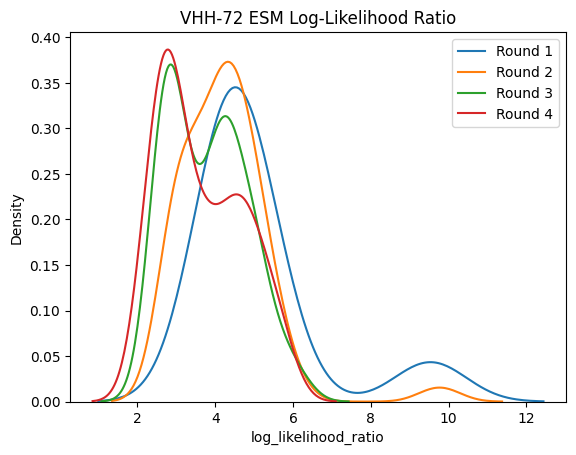

In [73]:
# Plot ESM scores across rounds (all top 20 designs per input nanobody sequence)
for nanobody in nanobodies:
    plt.clf()
    for round_num in range(1, max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}_all.csv"
        scores = pd.read_csv(scores_path)
        sns.kdeplot(data=scores, x="log_likelihood_ratio", label=f"Round {round_num}")
    plt.title(f"{nanobody} ESM Log-Likelihood Ratio")
    plt.legend()
    plt.show()

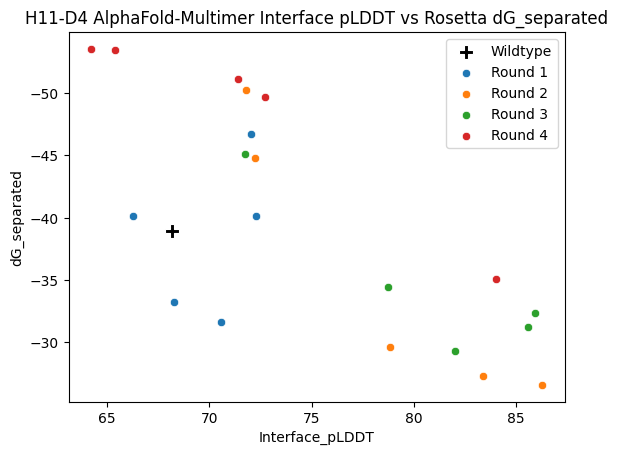

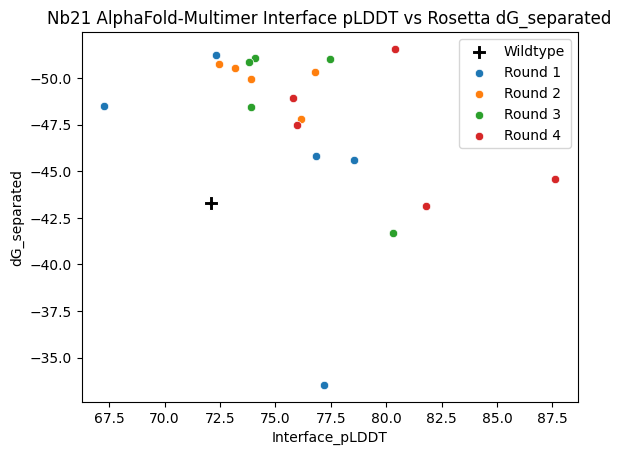

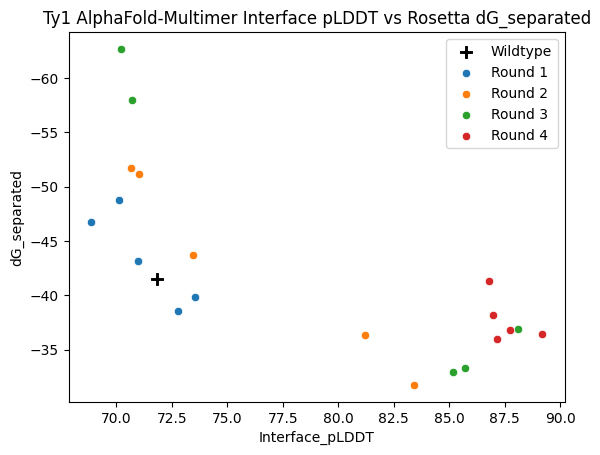

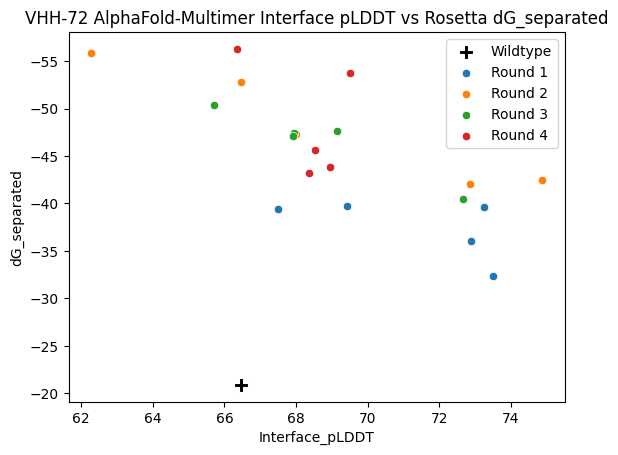

In [74]:
# Plot AlphaFold-Multimer ipLDDT vs Rosetta dG_separated scores across rounds (top 5 from each round)
for nanobody in nanobodies:
    plt.clf()
    for round_num in range(max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}.csv"
        scores = pd.read_csv(scores_path)
        kwargs = {"label": f"Round {round_num}"} if round_num > 0 else {"label": "Wildtype", "color": "black", "marker": "P", "s": 100, "zorder": 10}
        sns.scatterplot(data=scores, x="Interface_pLDDT", y="dG_separated", **kwargs)
    plt.gca().invert_yaxis()
    plt.title(f"{nanobody} AlphaFold-Multimer Interface pLDDT vs Rosetta dG_separated")
    plt.legend()
    plt.show()

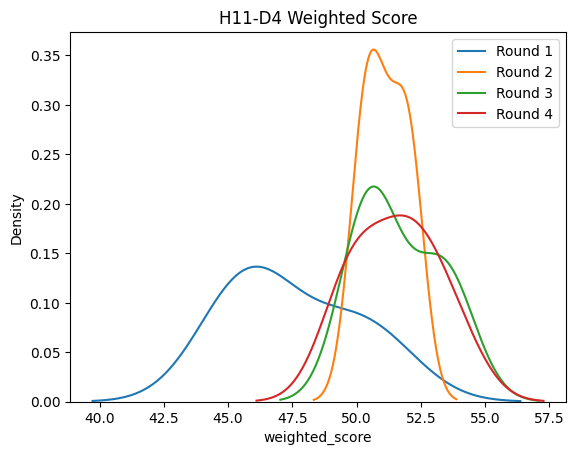

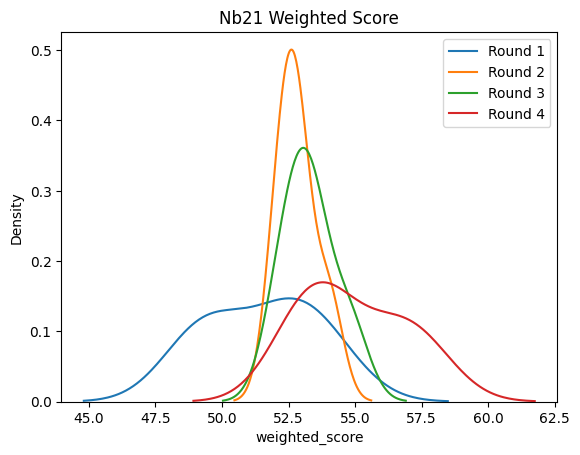

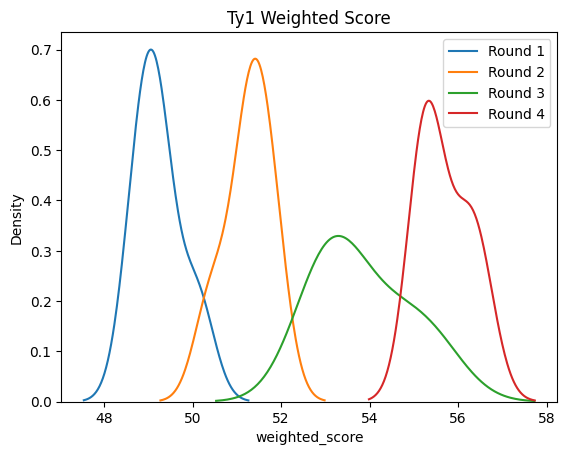

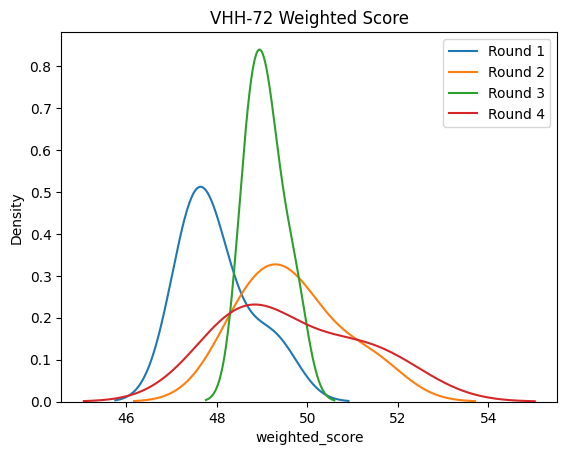

In [75]:
# Plot weighted scores of best designs across rounds
for nanobody in nanobodies:
    plt.clf()
    for round_num in range(1, max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}.csv"
        scores = pd.read_csv(scores_path)
        sns.kdeplot(data=scores, x="weighted_score", label=f"Round {round_num}")
    plt.title(f"{nanobody} Weighted Score")
    plt.legend()
    plt.show()

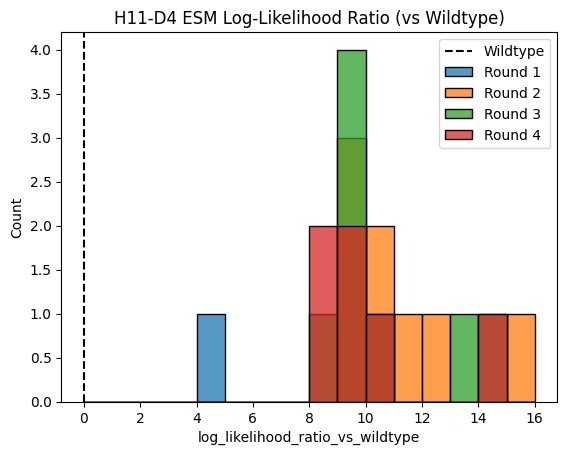

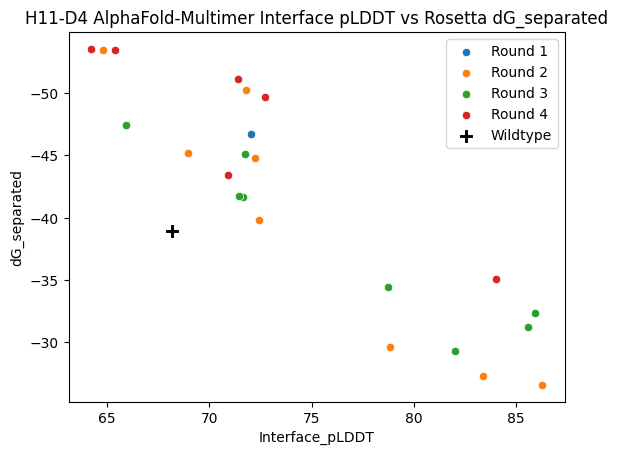

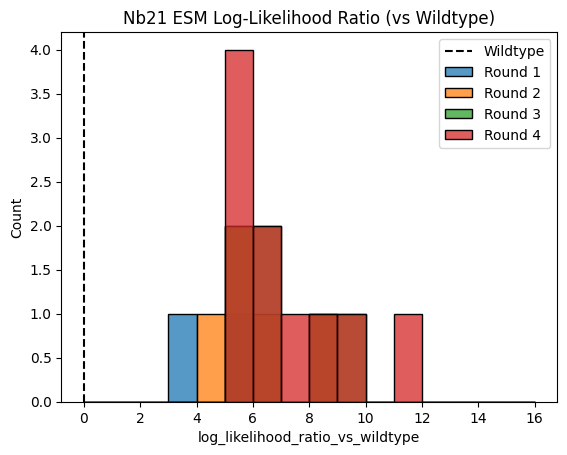

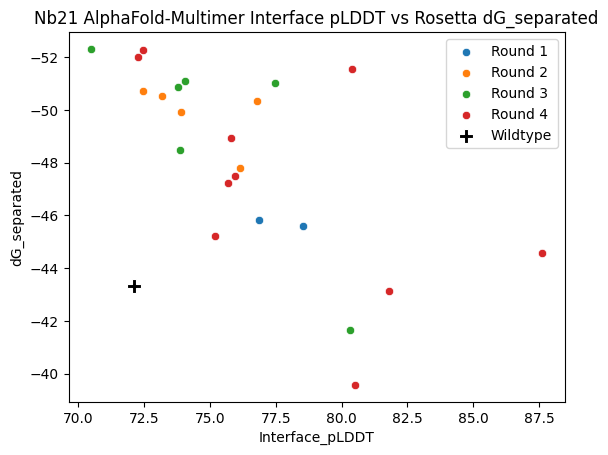

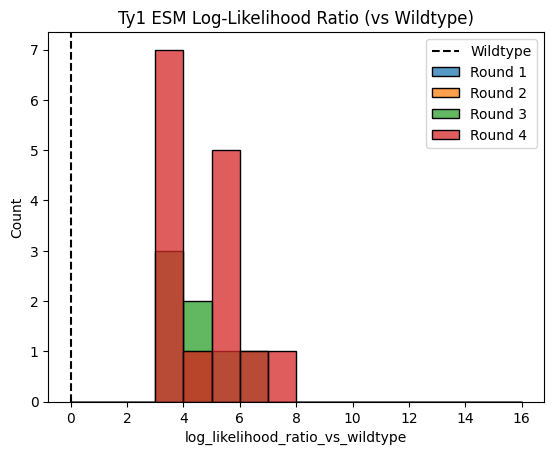

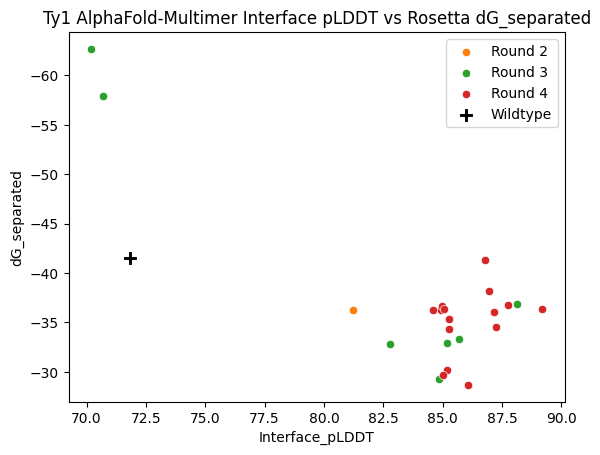

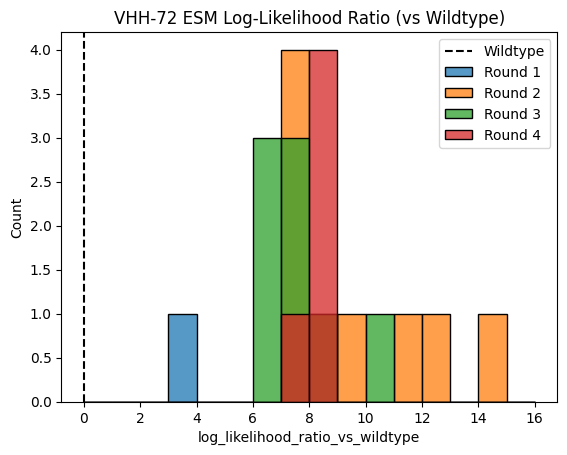

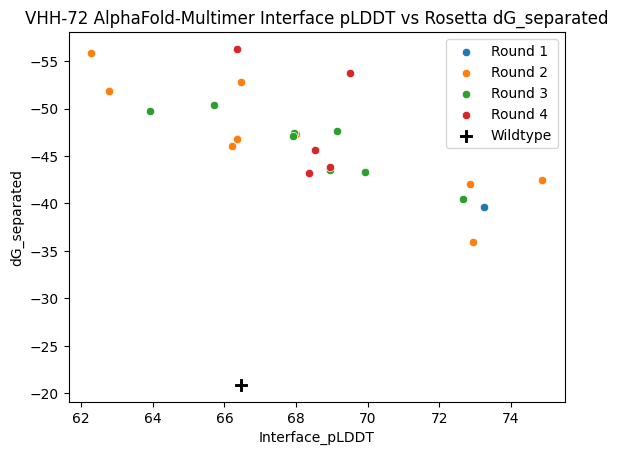

In [76]:
# Plot best designs for each nanobody
bins = np.linspace(0, 16, 17)
for nanobody in nanobodies:
    scores = pd.read_csv(combined_dir / f"{nanobody}.csv")
    scores["round_num"] = [len(name.replace(f"{nanobody}-", "").split("-")) for name in scores["name"]]
    designed = scores.iloc[:-1]
    wildtype = scores.iloc[-1:]

    # Plot ESM scores
    plt.clf()
    for round_num in range(1, max_round + 1):
        round_scores = designed[designed["round_num"] == round_num]
        sns.histplot(data=round_scores, x="log_likelihood_ratio_vs_wildtype", bins=bins, label=f"Round {round_num}")
    plt.axvline(wildtype.iloc[0]["log_likelihood_ratio_vs_wildtype"], color="black", linestyle="--", label="Wildtype")
    plt.title(f"{nanobody} ESM Log-Likelihood Ratio (vs Wildtype)")
    plt.legend()
    plt.show()

    # Plot AlphaFold-Multimer ipLDDT vs Rosetta dG_separated scores
    plt.clf()
    for round_num in range(1, max_round + 1):
        round_scores = designed[designed["round_num"] == round_num]
        sns.scatterplot(data=round_scores, x="Interface_pLDDT", y="dG_separated", label=f"Round {round_num}")
    sns.scatterplot(data=wildtype, x="Interface_pLDDT", y="dG_separated", label="Wildtype", color="black", marker="P", s=100, zorder=10)
    plt.gca().invert_yaxis()
    plt.title(f"{nanobody} AlphaFold-Multimer Interface pLDDT vs Rosetta dG_separated")
    plt.legend()
    plt.show()